In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from support import plot_mesh

Could not import module: serial


In [2]:
n_el = 16  # nb of electrodes
mesh_obj = mesh.create(n_el, h0=0.05, fd=thorax)

In [3]:
perm_l = list()
splts = 50
for lung_r in np.linspace(0.1, 0.4, splts):
    lung_anomaly_r = PyEITAnomaly_Circle(center=[0.5, 0], r=lung_r, perm=10.0)
    lung_anomaly_l = PyEITAnomaly_Circle(center=[-0.45, 0], r=lung_r, perm=10.0)

    mesh_obj = mesh.set_perm(
        mesh_obj, anomaly=[lung_anomaly_l, lung_anomaly_r], background=1.0
    )
    perm_l.append(len(np.where(mesh_obj.perm_array == 10)[0]))
    # plot_mesh(mesh_obj)

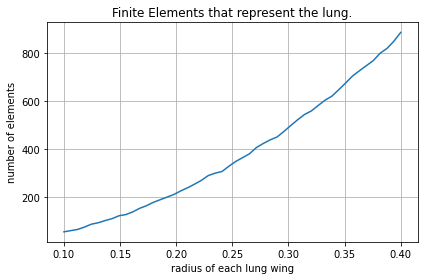

In [4]:
plt.figure(figsize=(6, 4))
plt.title("Finite Elements that represent the lung.")
plt.plot(np.linspace(0.1, 0.4, splts), perm_l)
plt.xlabel("radius of each lung wing")
plt.ylabel("number of elements")
plt.grid()
plt.tight_layout()
plt.show()

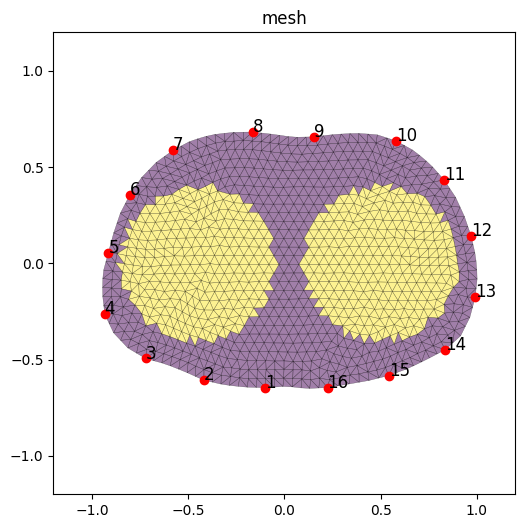

In [5]:
plot_mesh(mesh_obj)

## Create lung cyclus

In [129]:
splts = 51
r_min = 0.1
r_max = 0.4

r_up = np.linspace(r_min, r_max, splts-1, endpoint=False)
r_down = np.linspace(r_max, r_min, splts-1, endpoint=False)

r_period = np.concatenate((r_up,r_down))
r_noise = np.random.random(splts*2-2)/200

In [130]:
print(len(r_tot),len(r_noise))

100 100


Text(0.5, 0, 'time steps')

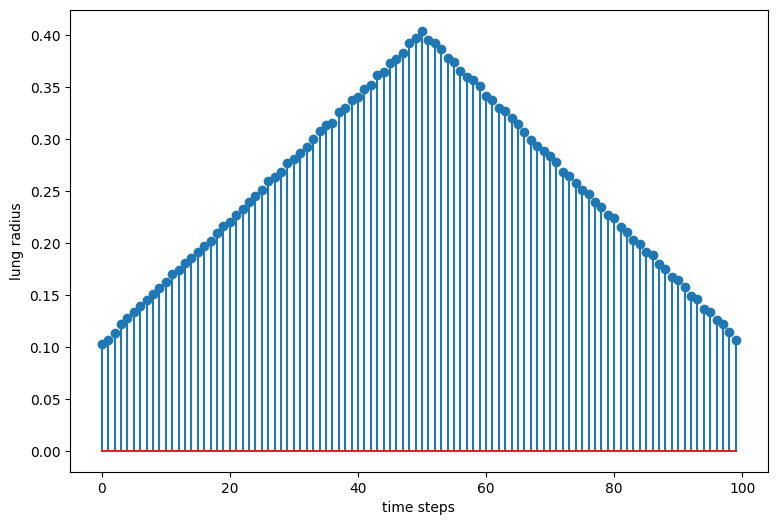

In [131]:
plt.figure(figsize=(9,6))
plt.stem(r_period+ r_noise)
plt.ylabel("lung radius")
plt.xlabel("time steps")

## Generate Data

In [132]:
import os

import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward
from pyeit.mesh import PyEITMesh
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from tqdm import tqdm

from codes.support import rphi_to_xy

n_diff_noises = 100
r_min = 0.1 # min lung radius
r_max = 0.4 # max lung radius
splts = 51 # splts*2-1 is the number or radial steps

print(f"num of samples = {n_diff_noises*(splts*2-2)}")

noise_div = 200

n_el = 16  # number of electrodes
h0 = 0.025
perm_obj = 100
dist_exc = 8
step_meas = 4


r_up = np.linspace(r_min, r_max, splts-1, endpoint=False)
r_down = np.linspace(r_max, r_min, splts-1, endpoint=False)

r_period = np.concatenate((r_up,r_down))

s_path = f"data_thorax/{h0=}_{n_el=}_{r_min=}_{r_max=}_{dist_exc=}_{step_meas=}/"

try:
    os.mkdir(s_path)
except BaseException:
    print(f"{s_path} already exist.")

s_idx = 0
for _ in range(n_diff_noises):
    # create noise vector
    r_noise = np.random.random(splts*2-2)/noise_div
    for lung_r in r_period+r_noise:
        # create meshes
        mesh_obj = mesh.create(n_el, h0=h0)
        mesh_empty = mesh.create(n_el, h0=h0)

        # generate data
        lung_anomaly_r = PyEITAnomaly_Circle(center=[0.5, 0], r=lung_r, perm=perm_obj)
        lung_anomaly_l = PyEITAnomaly_Circle(center=[-0.45, 0], r=lung_r, perm=perm_obj)

        mesh_obj = mesh.set_perm(
            mesh_obj, anomaly=[lung_anomaly_l, lung_anomaly_r], background=1.0
        )
        protocol_obj = protocol.create(
            n_el, dist_exc=dist_exc, step_meas=step_meas, parser_meas="std"
        )
        fwd_v = EITForward(mesh_empty, protocol_obj)
        v_empty = fwd_v.solve_eit(perm=mesh_empty.perm)
        v_obj = fwd_v.solve_eit(perm=mesh_obj.perm)

        np.savez(
            s_path + "sample_{:06d}.npz".format(s_idx),
            anomaly=[lung_anomaly_l, lung_anomaly_r],
            perm_array=mesh_obj.perm_array,
            n_el=n_el,
            h0=h0,
            v_empty=v_empty,
            v_obj=v_obj,
            dist_exc=dist_exc,
            step_meas=step_meas,
        )
        s_idx += 1


ModuleNotFoundError: No module named 'codes'